## Simulation-Based Inference SIR Model: Training
Created: May 23, 2022 Prosper and Prosper<br>
Updated: Apr 05, 2023 HBP<br>
Updated: Oct 30, 2023 HBP

### Introduction 

The purpose of this notebook is to approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ in two different ways: 1) using a 2D histogram and 2) a neural network, where for a given hypothesis $H_0: \theta = \theta_0$ versus $H_1: \theta \ne \theta_0$, $\lambda_0$ is the observed value of the test statistic $\lambda$ (see SIR_generate_data.ipynb for details.)

Our test statistic $\lambda$  is large for parameters $\theta$ *disfavored* by the data, whereas in the algorithm of Ref.[1], a modified version of which we use, $\lambda$ is small for disfavored parameters. Therefore, we're approximating the cumulative distribution function (cdf) rather than the p-value. 

The stochastic forward simulator $F_\theta$ is the CTMC simulator in notebook SIR_generate_data.ipynb, which simulates the ensemble of synthetic epidemics.


### Approximating $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming

The quantity $\mathbb{E}(Z | \theta)$ can be approximated using the following algorithm, which therefore provides a way to check the quality of the deep neural network model.

$\theta = \alpha, \beta$

  1. Create histogram $h_w \gets \text{histogram}(\alpha, \beta, \text{weight}=Z)$
  1. Create histogram $h_u \gets \text{histogram}(\alpha, \beta, \text{weight}=1)$
  1. Approximate $\mathbb{P}(\lambda \le \lambda_0 | \alpha, \beta)$ by $h_w \, / \, h_u$

### References
  1. Ann Lee *et al.*, https://arxiv.org/abs/2107.03920

In [1]:
import os, sys

sys.path.append('../')

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# module to save results
#import joblib as jb

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

import SIR_dnn_util as ut
from SIR_gen_util import Fsolve, test_statistic, SIRdata

%matplotlib inline

device: cpu


In [53]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 217
rnd  = np.random.RandomState(seed)

### Load data

__Note__: The $\alpha$ and $\beta$ parameters have been scaled so that they are of $\cal{O}(1)$. Therefore, no further transformation is needed.

In [54]:
print('SIRdata')
data = SIRdata
data.alpha_min,  data.alpha_max = 0.10, 0.90
data.beta_min,   data.beta_max  = 0.25, 0.65
print(data)
print()

DSIZE = '110k'

datafile = f'../data/SIR_traindata_{DSIZE:s}.csv.gz'

print('loading %s' % datafile)
df = pd.read_csv(datafile)
print('number of rows:', len(df))

df[:5]

SIRdata
 D           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 I0          : 3
 O           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 R0          : 0
 S0          : 763
 T           : [ 0  2  3  4  5  6  7  8  9 10 11 12 13]
 alpha0      : 0.465
 alpha_bins  : 10
 alpha_max   : 0.9
 alpha_min   : 0.1
 alpha_scale : 1.0
 beta0       : 0.00237
 beta_bins   : 10
 beta_max    : 0.65
 beta_min    : 0.25
 beta_scale  : 0.005
 model       : SIR
 scale       : 50
 tmax        : 14.0
 tmin        : 0.0


loading ../data/SIR_traindata_110k.csv.gz
number of rows: 110000


,alpha,beta,li,lo,l0,Zo,Z0,i,I
0,0.556824,0.432547,0.015810,0.629072,0.068463,1.0,1.0,"[3, 33, 61, 149, 208, 217, 181, 125, 85, 61, 3...","[3.0, 25.41, 66.24, 140.76, 212.17, 226.2, 190..."
1,0.917183,0.617733,0.037291,0.150635,0.323215,1.0,1.0,"[3, 19, 101, 180, 180, 125, 72, 38, 21, 7, 9, ...","[3.0, 46.43, 126.68, 188.65, 160.33, 101.22, 5..."
2,0.222595,0.684092,0.022214,0.545157,0.178384,1.0,1.0,"[3, 271, 514, 499, 413, 325, 265, 201, 155, 12...","[3.0, 232.07, 521.39, 511.27, 423.76, 341.88, ..."
3,0.513685,0.231400,0.098132,0.418606,0.630670,1.0,1.0,"[3, 6, 11, 23, 39, 63, 81, 97, 95, 98, 75, 59,...","[3.0, 6.22, 8.89, 12.59, 17.59, 24.14, 32.47, ..."
4,0.533168,0.343659,0.047897,0.071392,0.198700,1.0,1.0,"[3, 8, 19, 30, 52, 97, 150, 151, 124, 125, 106...","[3.0, 13.87, 28.69, 55.72, 97.06, 143.04, 172...."


In [55]:
def plot_data(d, filename='../images/fig_SIR_flu_data.pdf', fgsize=(5, 4), ftsize=14):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    # pad
    #plt.subplots_adjust(hspace=0.01)
    #plt.subplots_adjust(wspace=0.3)

    #
    xmin, xmax = 0,  18
    ymin, ymax = 0, 400

    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$t$ (day)', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'infected (count)', fontsize=ftsize)
    
    ax.scatter(d.T, d.D, s=20, c='black', 
               label=r'number of individuals in class $I$')
    ax.legend(fontsize=14)
               
    ax.grid() 
    
    plt.tight_layout()
    plt.savefig(filename)
    print(filename)

../images/fig_SIR_flu_data.pdf


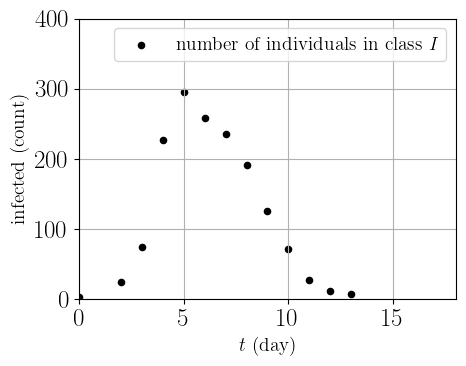

In [56]:
plot_data(SIRdata)

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

train set size:        100000
validation set size:     5000
test set size:           5000
    9
saved to file: fig_cset_by_hist.png


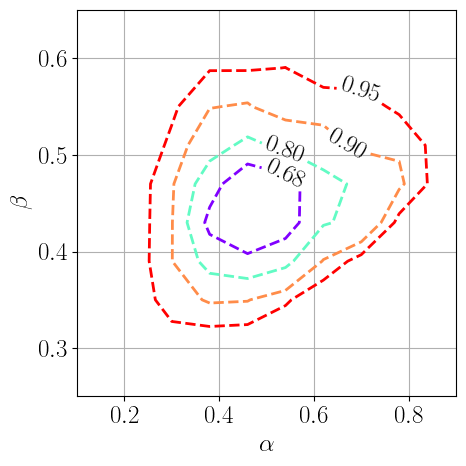

In [57]:
# Fraction of the data assigned as test data and validation
tfraction = 5/110 # test fraction, rest for training
vfraction = 5/110
tdata     = df

SIRdata.alpha_bins = 10
SIRdata.beta_bins  = 10

# Split data into a part for training and a part for testing
train_data, valid_data, test_data = ut.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

def smooth_hist(tfraction=2/3, K=10, d=SIRdata):
    P = np.zeros((data.alpha_bins, d.beta_bins))
    for k in range(K):
        print('\r%5d' % k, end='')
        _, test   = train_test_split(df, 
                                 test_size=tfraction, 
                                 shuffle=True)
        p, xe, ye = ut.hist_data(test, SIRdata)
        P += p
    print()
    P /= K
    return P, xe, ye

hist = smooth_hist()

ut.plot_model(tdata, SIRdata, 
              filename='fig_cset_by_hist.png')

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined by

\begin{align}
R_M(\theta) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta).
\end{align*}

The empirical risk $R_M$ approximates the __risk functional__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x} .
\end{align}

The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

We use the __quadratic loss__

\begin{align}
    L(t, f) &= (t - f)^2 .
\end{align}

### Define model $f(\alpha, \beta, \lambda; \omega)$

For simple models, it is sufficient to use the __Sequential__ class.

In [58]:
%%writefile ../models/SIR_dnn_cdf_100k.py

name     = 'SIR_dnn_cdf_100k'
features = ['alpha', 'beta', 'lo']
target   = 'Zo'
nodes    =  12
gsize    =  4

import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.module = nn.Sequential(nn.Linear(nodes, nodes), 
                                    nn.ReLU(),
                                    nn.Linear(nodes, nodes), 
                                    nn.ReLU())

    def forward(self, input):
        return self.module(input) + input


# Based on code written by ChatGPT v3.5
class GroupSort(nn.Module):
    def __init__(self, group_size=2):
        super().__init__()
        self.group_size = group_size
        
    def forward(self, input):
        """
        Splits input tensor into groups of size 'group_size' and sorts each group                 independently.
    
        Args:
            input (torch.Tensor): The input tensor to be sorted.
    
        Returns:
            torch.Tensor: The sorted tensor, with elements grouped and sorted in                      ascending order.
        """
        # Reshape the input tensor into groups of size 'group_size'
        grouped_tensor = input.view(-1, self.group_size)
    
        # Sort each group individually using torch.sort
        sorted_groups, _ = torch.sort(grouped_tensor)
        
        # Flatten the sorted tensor
        sorted_tensor = sorted_groups.reshape(input.shape)
    
        return sorted_tensor

model = nn.Sequential(nn.Linear(len(features), nodes),
                      GroupSort(gsize),

                      nn.Linear(nodes, nodes), 
                      GroupSort(gsize), 
                      
                      nn.Linear(nodes, nodes), 
                      GroupSort(gsize),
                      
                      nn.Linear(nodes, 1),  
                      nn.Sigmoid()
                     )

Overwriting ../models/SIR_dnn_cdf_100k.py


In [59]:
import models.SIR_dnn_cdf_100k as NN
importlib.reload(NN)
name     = NN.name
model    = NN.model
features = NN.features
target   = NN.target

modelfile  = '../models/%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d' % ut.number_of_parameters(model))

SIR_dnn_cdf_100k
Sequential(
  (0): Linear(in_features=3, out_features=12, bias=True)
  (1): GroupSort()
  (2): Linear(in_features=12, out_features=12, bias=True)
  (3): GroupSort()
  (4): Linear(in_features=12, out_features=12, bias=True)
  (5): GroupSort()
  (6): Linear(in_features=12, out_features=1, bias=True)
  (7): Sigmoid()
)
number of parameters: 373


### Train!

In [60]:
traces = ([], [], [])
traces_step = 10

Iteration vs average loss
iteration train-set valid-set
0        0 0.2856483 0.2853546
10       10 0.2826959 0.2824003
20       20 0.2795735 0.2792978
30       30 0.2763177 0.2760676
40       40 0.2730157 0.2727810
148728070 0.0320339 0.0354754   1487270:    987270/0.03535673/   500000

stopping early!

Iteration vs average loss
iteration train-set valid-set
500107280 0.0322180 0.0355807     50000:         0/0.03535555/    50000

stopping early!



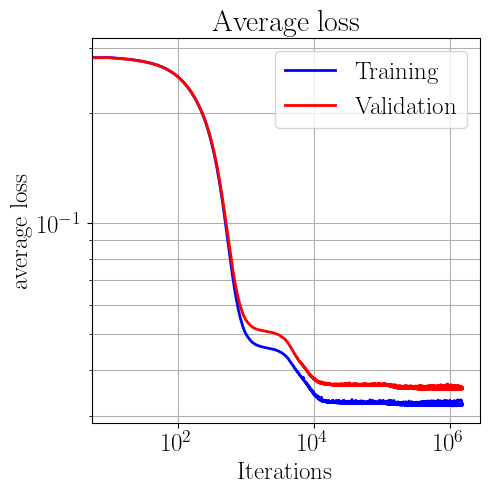

In [61]:
n_batch       = 128
n_iterations  = 10000000
early_stopping= 500000
learning_rate = 1.e-4

av_loss = ut.average_quadratic_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

traces = ut.train(model, optimizer, 
                  modelfile, early_stopping,
                  av_loss,
                  ut.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

n_batch       = 1024
n_iterations  = 10000000
early_stopping= 50000
learning_rate = 1.e-5

traces = ut.train(model, optimizer, 
                  modelfile, early_stopping,
                  av_loss,
                  ut.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

ut.plot_average_loss(traces)

### Plot results of trained model

In [50]:
import SIR_gen_util as gt
importlib.reload(gt)

def dnn(x, y, d, f=model):
    l = np.array(gt.test_statistic(x, y, d))
    I = np.array([x, y, l]).T
    X = torch.Tensor(I)
    
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    Y = model(X).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

In [62]:
Load_model = True
print('load model: %s' % modelfile)

if Load_model:
    modeldict = torch.load(modelfile)
    NN.model.load_state_dict(modeldict)

load model: ../models/SIR_dnn_cdf_100k.dict


device: cpu
alpha:      0.473, beta:      0.443*5.0e-03, min(fun):      0.475
                   beta:      0.00221
saved to file: ../images/fig_SIR_dnn_cdf_100k.pdf


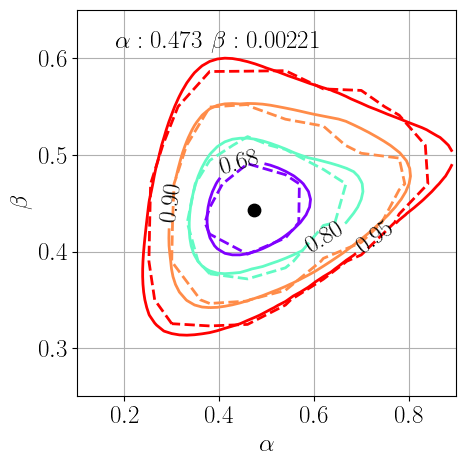

In [63]:
import SIR_dnn_util as ut
importlib.reload(ut)

SIRdata.O = SIRdata.D
res = ut.best_fit(ut.nll, dnn, SIRdata)

ut.plot_model(test_data, SIRdata, dnn, res, hist=hist,
              filename='../images/fig_%s.pdf' % NN.name)

In [24]:
def cdf(x, y, z):
    X = np.array([x, y, z]).T
    inputs = torch.Tensor(X)
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    Y = model(inputs).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

In [25]:
select = cdf(test_data.alpha, test_data.beta, test_data.l0) <= 0.95
CL95   = test_data[['alpha', 'beta', 'i']][select]
CL95.to_csv('../data/SIR_CL95.csv.gz', index=False, compression='gzip')
len(CL95)

2128